# Postprocessing using only position information

In [56]:
import pandas as pd
import numpy as np
# from pca import pca
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from pykalman import KalmanFilter
from ppca import PPCA


In [57]:
# Get the final 3d tracks from a project
# project_fname = "Charlie-immobilized-long";
project_fname = "Charlie-worm3-new-seg";

# FILTERED BY DLC
fname = f"Y:/shared_projects/wbfm/dlc_stacks/{project_fname}/3-tracking/full_3d_tracks.h5"
df_raw = pd.read_hdf(fname)


# Remove multiindex and likelihood elements
df_with_likelihood = df_raw.copy()
df_with_likelihood.columns = ["_".join(a) for a in df_with_likelihood.columns.to_flat_index()]
to_keep = [c for c in df_with_likelihood.columns if 'likelihood' not in c.lower()]
df = df_with_likelihood[to_keep].copy()


In [58]:

df.replace(0, np.NaN, inplace=True)
# Impute zero values to be mean of the column
# Note: only works because this is immobilized data
df.head()
df.fillna(df.mean(), inplace=True)
df = df.diff()[1:] # Remove initial time point; should be one shorter
# df.replace(np.NaN, 0, inplace=True)
df.head()

,neuron1550_y,neuron1550_x,neuron1550_z,neuron1673_y,neuron1673_x,neuron1673_z,neuron2224_z,neuron2224_x,neuron2224_y,neuron3529_z,...,neuron5459_z,neuron5464_x,neuron5464_y,neuron5464_z,neuron5465_z,neuron5465_y,neuron5465_x,neuron67_x,neuron67_y,neuron67_z
1,13.790812,-14.395625,0.0,0.000000,0.000000,0.0,0.0,13.484613,-42.290204,0.0,...,0.0,253.055955,-30.119307,0.0,0.0,0.000000,0.000000,4.615796,-88.519463,0.0
2,-6.255539,-2.182266,0.0,0.000000,0.000000,0.0,0.0,-20.502206,13.815290,0.0,...,0.0,-252.735643,-13.914491,0.0,0.0,-184.172055,344.098038,-21.533978,65.002312,0.0
3,-15.100899,-8.446899,0.0,0.000000,0.000000,0.0,0.0,-12.376099,-17.778193,0.0,...,0.0,252.735643,13.914491,0.0,0.0,184.172055,-344.098038,21.533978,-65.002312,0.0
4,-0.865576,-55.743145,0.0,0.000000,0.000000,0.0,0.0,-1.024582,3.408457,0.0,...,0.0,0.000000,0.000000,0.0,0.0,-80.065381,101.337235,0.000000,0.000000,0.0
5,-32.726618,73.227530,0.0,-58.521813,94.640136,0.0,0.0,7.948776,14.911728,0.0,...,0.0,-205.671403,145.755820,0.0,0.0,-16.791168,-40.337311,-6.981549,64.329918,0.0


In [59]:
# Do PCA projection and remove outliers
# https://github.com/erdogant/pca

# First just do PCA and plot it
# model = pca(n_components=10)
# results = model.fit_transform(df)
# model.plot()
pca = TruncatedSVD(n_components=20)
df_new = pca.fit_transform(df)

In [60]:
plt.plot(pca.explained_variance_ratio_)

In [61]:
df_projected = pca.inverse_transform(df_new)

In [62]:
# Recover dataframe columns; NOT yet multi-index format
df_projected = pd.DataFrame(df_projected, columns=df.columns)


In [63]:
df_projected.columns

Index(['neuron1550_y', 'neuron1550_x', 'neuron1550_z', 'neuron1673_y',
       'neuron1673_x', 'neuron1673_z', 'neuron2224_z', 'neuron2224_x',
       'neuron2224_y', 'neuron3529_z',
       ...
       'neuron5459_z', 'neuron5464_x', 'neuron5464_y', 'neuron5464_z',
       'neuron5465_z', 'neuron5465_y', 'neuron5465_x', 'neuron67_x',
       'neuron67_y', 'neuron67_z'],
      dtype='object', length=222)

In [64]:
from numpy import ma
from sklearn.covariance import EllipticEnvelope
# from sklearn.neighbors import LocalOutlierFactor

outliers_fraction = 0.3
# , contamination=outliers_fraction
# outlier_func = LocalOutlierFactor(n_neighbors=50, metric='l2')
# outlier_func = EllipticEnvelope(contamination=outliers_fraction, support_fraction=0.99)

name = 'neuron1550'
name_x = '_'.join([name, 'x'])
name_y = '_'.join([name, 'y'])

print(f"Analyzing: {name}")
derivs = np.array(df_projected[name_x])
vals = np.array(df_raw[name]['x'][:-1])
# Missing due to low DLC confidence
likelihood_thresh = 0.6
low_likelihood = df_raw[name]['likelihood'][:-1] < likelihood_thresh

# Missing due to outlier derivative (same for x and y)
xy_derivs = np.array(df_projected[[name_x, name_y]])
# outlier_ind = outlier_func.fit(xy_derivs).predict(xy_derivs)
# outlier_ind = outlier_func.fit_predict(xy_derivs)
# is_outlier = outlier_ind==0
is_outlier = False

# Use numpy masked arrays to incorporate missing value
derivs = ma.masked_array(derivs, mask=is_outlier, fill_value=0) # Derivs are good even at bad DLC locations
vals = ma.masked_array(vals, mask=low_likelihood|is_outlier, fill_value=0) 

# Apply projected corrections via a kalman filter
A = np.array([[1.0, 1.0], 
              [0.0, 0.9]]) # Position and velocity
C = np.array([[1.0, 0.0], 
              [0.0, 1.0]]) # Both are observed
measurements = ma.vstack([vals, derivs]).T
initial_state_mean = np.array([vals[0], 0.0])
observation_covariance = np.array([[1e-1, 0.0], 
                                   [0.0, 1e-2]])
# A = np.array([[1.0, 1.0, 0.0], 
#               [0.0, 1.0, -0.1], 
#               [0.0, 0.0, 1.0]]) # Position and velocity and v^squared
# C = np.array([[1.0, 0.0, 0.0], 
#               [0.0, 1.0, 0.0], 
#               [0.0, 0.0, 1.0]]) # Position and velocity only are observed
# initial_state_mean = np.array([vals[0], 0.0, 0.0])
# measurements = ma.vstack([vals, derivs, derivs**2]).T
# observation_covariance = np.array([[2.0, 0.0, 0.0], 
#                                    [0.0, 1e-3, 0.0], 
#                                    [0.0, 0.0, 1e-4]])
kf = KalmanFilter(transition_matrices=A,
                  observation_matrices=C,
                  observation_covariance=observation_covariance,
                  initial_state_mean=initial_state_mean,
                  em_vars=['transition_covariance', 'observation_covariance'])

Analyzing: neuron1550


In [65]:
kf = kf.em(measurements, n_iter=2)
# (filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)

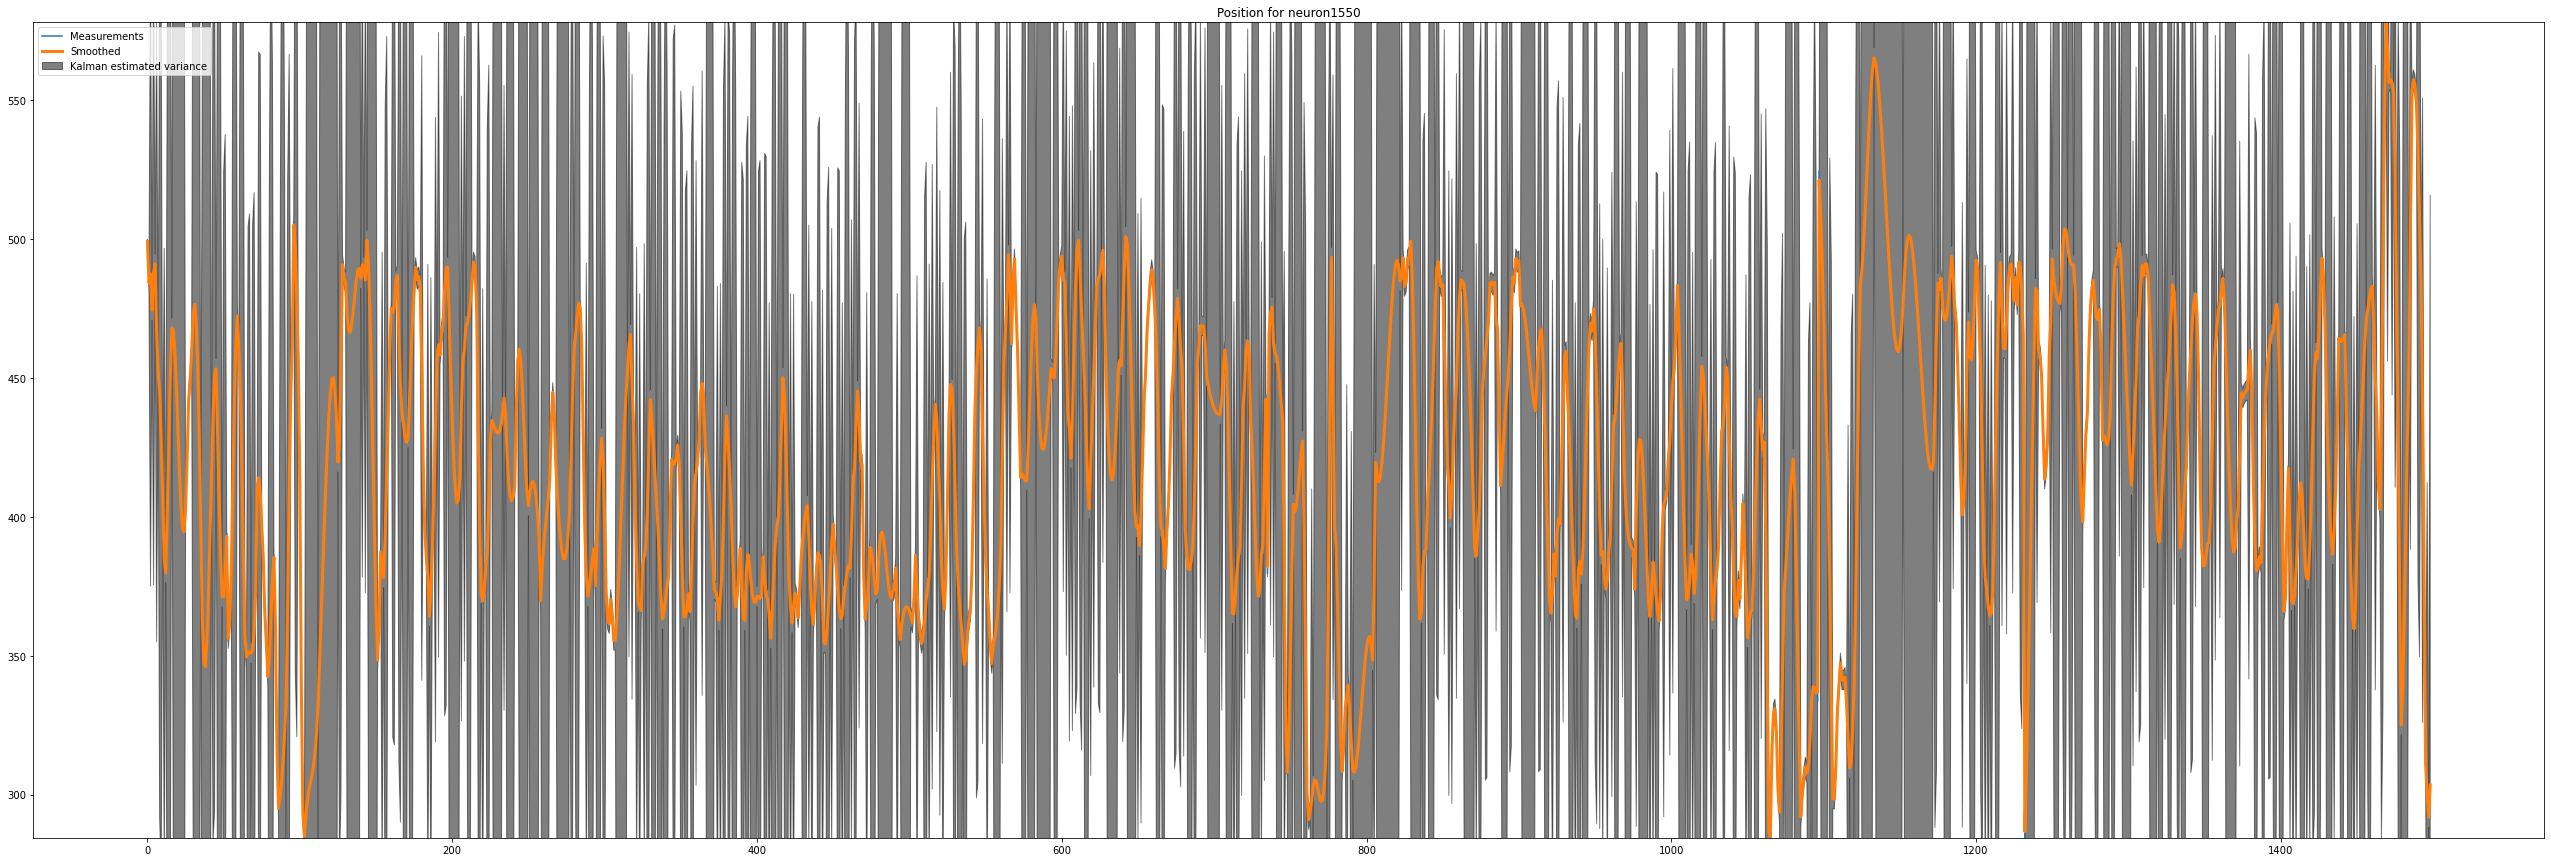

In [38]:
%matplotlib inline
plt.figure(figsize=(45,15))
which_dim = 0
plt.title(f"Position for {name}")
plt.plot(measurements[:,which_dim], label="Measurements")
y = smoothed_state_means[:,which_dim]
plt.plot(y, label="Smoothed", lw=3)
err = smoothed_state_covariances[:,which_dim,which_dim]
plt.fill_between(range(len(y)), y+err, y-err, label="Kalman estimated variance", color='k', alpha=0.5)
# plt.ylim([min(measurements[:,which_dim]), max(measurements[:,which_dim])])
plt.ylim([min(y), max(y)])
plt.legend()
plt.savefig(f'Kalman_test_{name}.png')

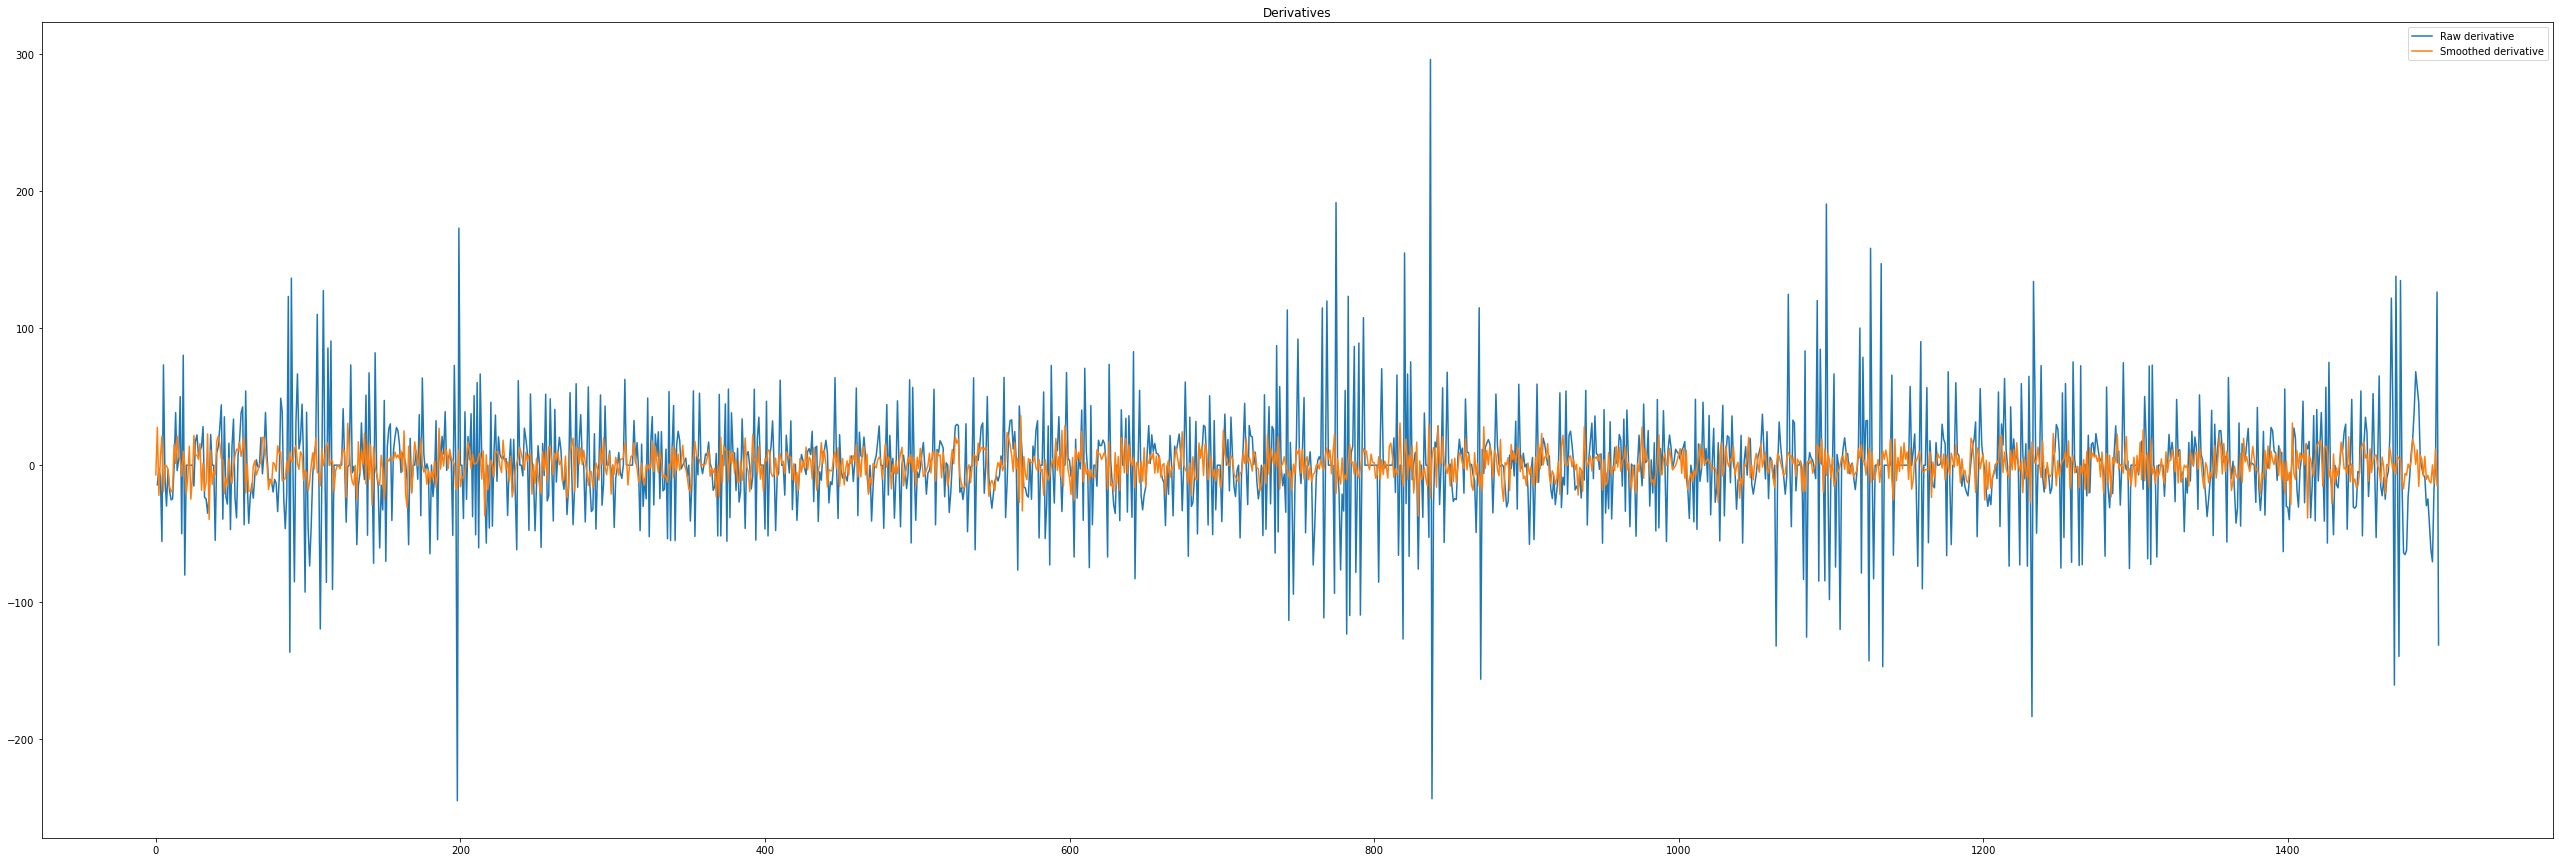

In [39]:
plt.figure(figsize=(45,15))
plt.plot(df[name_x], label="Raw derivative")
plt.plot(measurements[:,1], label="Smoothed derivative")
plt.title("Derivatives")
plt.legend()

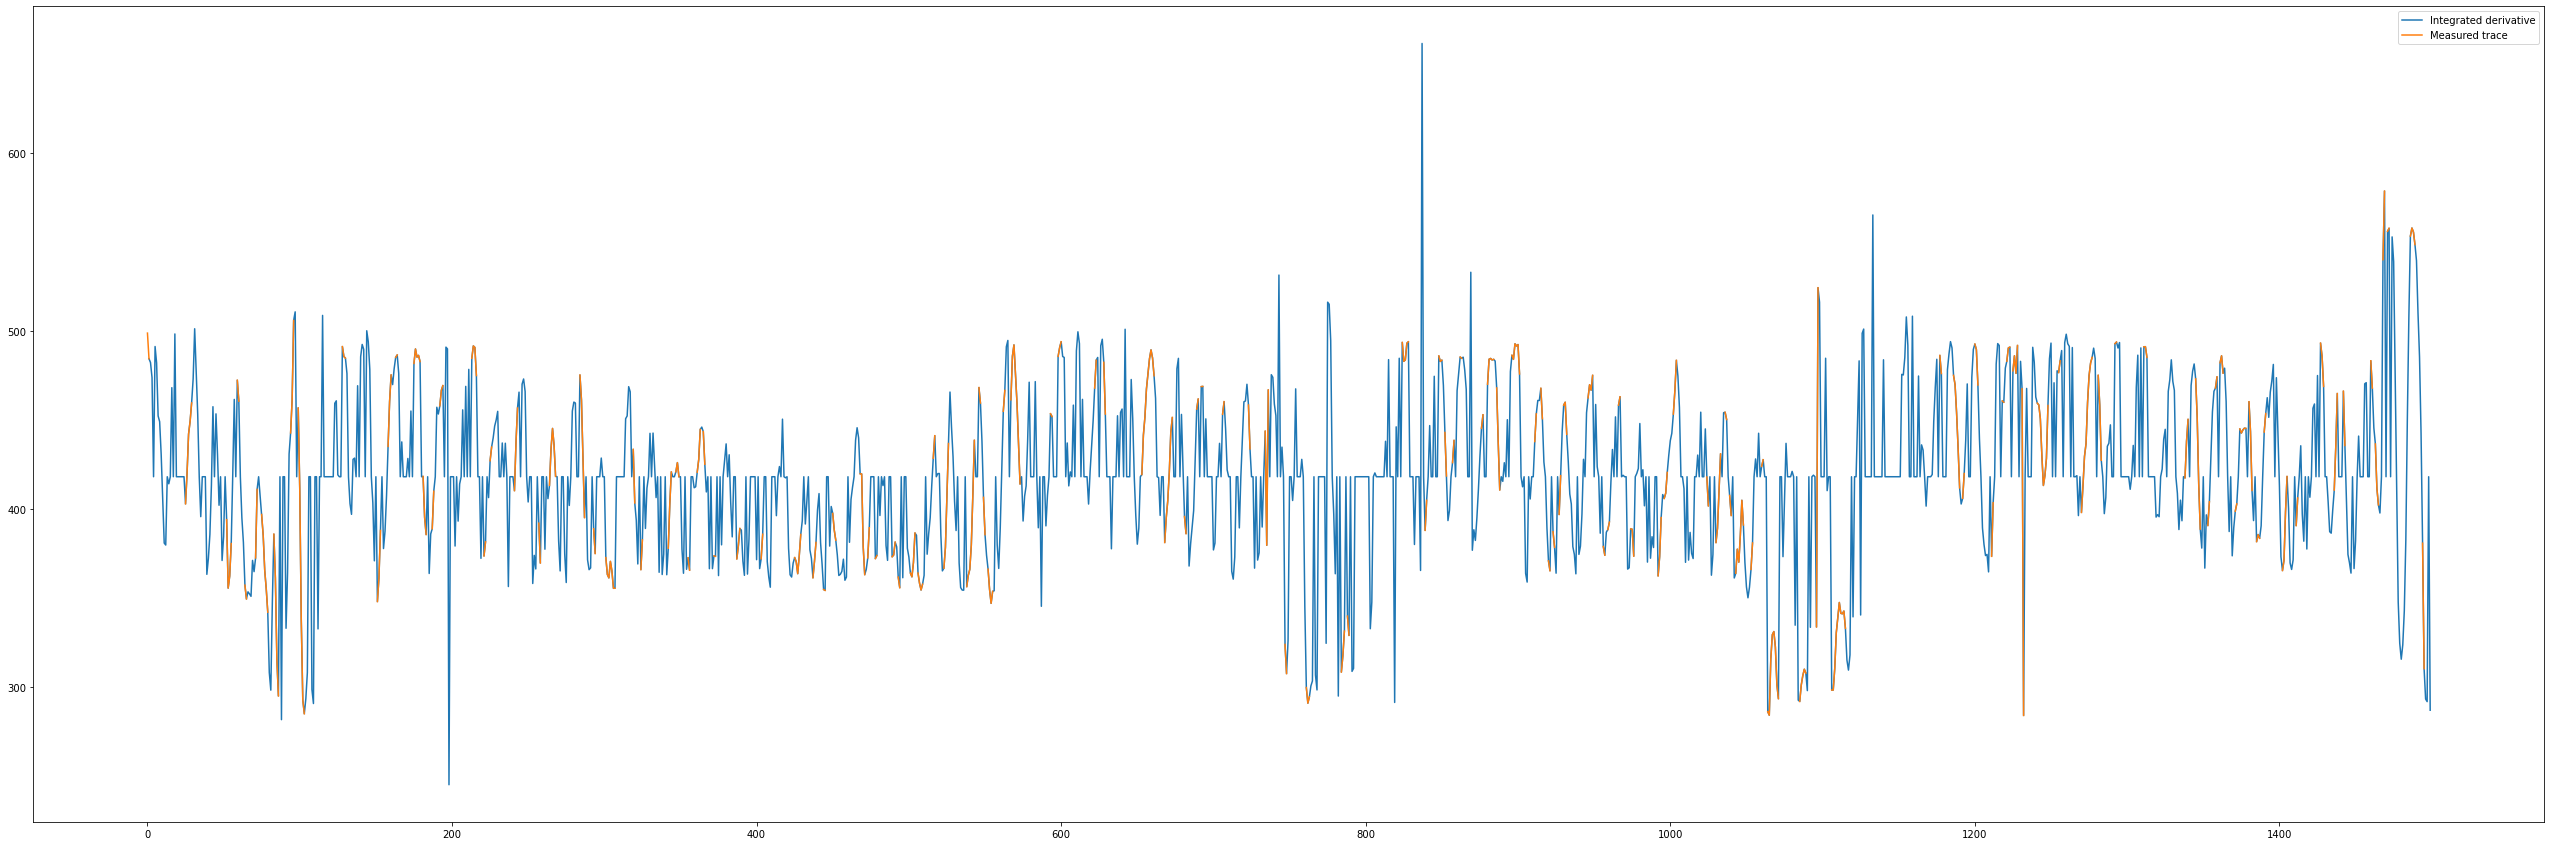

In [26]:
plt.figure(figsize=(45,15))
plt.plot(measurements[0,0] + np.cumsum(df[name_x]), label="Integrated derivative")
plt.plot(measurements[:,0], label="Measured trace")
plt.legend()

ValueError: Digital filter critical frequencies must be 0 < Wn < fs/2 (fs=1 -> fs/2=0.5)

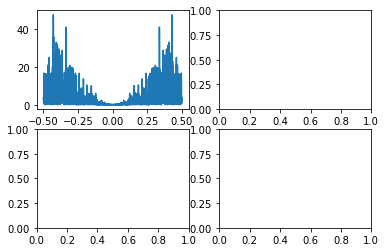

In [173]:
# Power spectrum of the derivative

fig, ax = plt.subplots(2,2)
data = measurements[:,1]
ps = np.abs(np.fft.fft(data))**2

time_step = 1
freqs = np.fft.fftfreq(data.size, time_step)
idx = np.argsort(freqs)

ax[0][0].plot(freqs[idx], ps[idx])
# ax[0][0].xlim([0, 0.5])

from scipy import signal
sos = signal.butter(10, 15, 'hp', fs=1, output='sos')
filtered = signal.sosfilt(sos, data)

ps = np.abs(np.fft.fft(filtered))**2

time_step = 1
freqs = np.fft.fftfreq(filtered.size, time_step)
idx = np.argsort(freqs)

ax[1][0].plot(freqs[idx], ps[idx])
# ax[1][0].xlim([0, 0.5])

In [85]:
# good = (df_raw[which_neuron]['likelihood'][1:] > likelihood_thresh) & (outlier_ind==1)

# plt.plot(df_raw[which_neuron]['x'][1:][good], df_raw[which_neuron]['y'][1:][good])

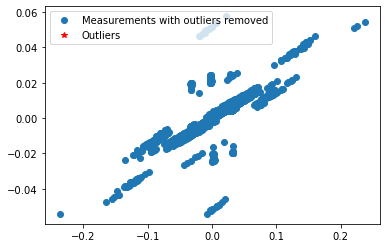

In [86]:
# Just plot the outliers
plt.plot(xy_derivs[:,0], xy_derivs[:,1], 'o', label="Measurements with outliers removed")
x_outlier = np.where(is_outlier)[0]
plt.plot(xy_derivs[x_outlier,0], xy_derivs[x_outlier,1], 'r*', label="Outliers", lw=5)
# plt.plot(x_outlier, np.array(df_projected[name_x])[x_outlier], 'r*', label="Outliers", lw=5)
plt.legend()

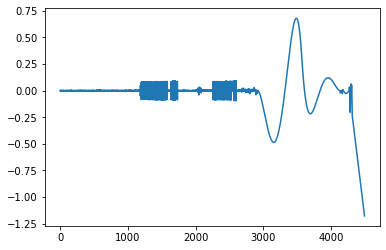

In [488]:
plt.plot(y)

In [66]:
measurements

masked_array(
  data=[[498.91587320963544, -6.359236263856659],
        [484.52024841308594, 26.981015848727413],
        [--, -19.2108367545567],
        [473.8910827636719, 3.790940429741778],
        [--, 20.44819449408858],
        [491.37546793619794, -20.153920267897586],
        [--, 0.17550199580406195],
        [452.33641560872394, 0.4804331876461467],
        [--, -3.5661199461037256],
        [--, -14.962478038972925],
        [405.49387613932294, -19.884355170475093],
        [--, -17.722505839916128],
        [379.74351501464844, 15.504149121935855],
        [--, 0.6713148552349698],
        [--, 22.027026718793056],
        [--, 6.153680030509715],
        [468.2345479329427, 4.6017125644761],
        [--, -6.3995726939160855],
        [--, 8.38396360233224],
        [--, 0.44675889991506657],
        [--, -21.442233991675085],
        [--, -10.691217931343518],
        [--, 16.613956039748864],
        [--, -27.114784671965754],
        [--, -9.584604777943508],
        

In [65]:
# Loop through each neuron, and:
# Loop through time points, then:
# if the likelihood is too low, then:
# replace point via path integration from previous point
df_corrected = df_raw.copy()
raw_names = df_raw.columns.levels[0]
projected_names = df_projected.columns # Includes XYZ coordinate in name
tspan = list(range(len(df_raw)))
likelihood_thresh = 0.8
for name in neuron_names:
    these_projected_cols = np.where([name in proj.split('_') for proj in projected_names])[0]
    key = (name, 'likelihood')
    for i_t in tspan:
        this_thresh = df_raw[key]

[0 1 2]
[3 4 5]
[6 7 8]
[ 9 10 11]
[12 13 14]
[15 16 17]
[18 19 20]
[21 22 23]
[24 25 26]
[27 28 29]
[30 31 32]
[33 34 35]
[36 37 38]
[39 40 41]
[42 43 44]
[45 46 47]
[48 49 50]
[51 52 53]
[54 55 56]
[57 58 59]
[60 61 62]
[63 64 65]
[66 67 68]
[69 70 71]
[72 73 74]
[75 76 77]
[78 79 80]
[81 82 83]
[84 85 86]
[87 88 89]
[90 91 92]
[93 94 95]
[96 97 98]
[ 99 100 101]
[102 103 104]
[105 106 107]
[108 109 110]
[111 112 113]
[114 115 116]
[117 118 119]
[120 121 122]
[123 124 125]
[126 127 128]
[129 130 131]
[132 133 134]
[135 136 137]
[138 139 140]
[141 142 143]
[144 145 146]
[147 148 149]
[150 151 152]
[153 154 155]
[156 157 158]
[159 160 161]
[162 163 164]
[165 166 167]
[168 169 170]
[171 172 173]
[174 175 176]
[177 178 179]
[180 181 182]
[183 184 185]
[186 187 188]
[189 190 191]
[192 193 194]
[195 196 197]
[198 199 200]
[201 202 203]
[204 205 206]
[207 208 209]
[210 211 212]
[213 214 215]
[216 217 218]
[219 220 221]
[222 223 224]
[225 226 227]
[228 229 230]
[231 232 233]
[234 235 236]
[2

# Alternative: use PPCA to impute instead of kalman anything

In [64]:
from sklearn.preprocessing import StandardScaler

In [65]:
# Get the final 3d tracks from a project
# project_fname = "Charlie-immobilized-long";
project_fname = "Charlie-worm3-new-seg";

# FILTERED BY DLC
fname = f"Y:/shared_projects/wbfm/dlc_stacks/{project_fname}/3-tracking/full_3d_tracks.h5"
df_raw = pd.read_hdf(fname)

# Remove multiindex and likelihood elements
df_with_likelihood = df_raw.copy()
df_with_likelihood.columns = ["_".join(a) for a in df_with_likelihood.columns.to_flat_index()]
to_keep = [c for c in df_with_likelihood.columns if 'likelihood' not in c.lower()]
df = df_with_likelihood[to_keep].copy()

In [66]:
# DLC uses zeros as "failed tracking"
df.replace(0, np.NaN, inplace=True)

df_dat = df.to_numpy()
scaler = StandardScaler()
scaler.fit(df_dat)
dat_normalized = scaler.transform(df_dat)

In [81]:
# OR: do probabilistic PCA
ppca2 = PPCA()
ppca2.fit(data=dat_normalized, d=2, verbose=False)

ppca10 = PPCA()
ppca10.fit(data=dat_normalized, d=4, verbose=False)

C:\Users\charles.fieseler\Anaconda3\envs\DLC-for-WBFM\lib\site-packages\ppca\_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds


In [82]:
which_neuron = 'neuron1550_x'
all_neurons = list(df.columns)
i_neuron = all_neurons.index(which_neuron)

dat_raw = dat_normalized[:, i_neuron]
dat_impute2 = ppca2.data[:, i_neuron]
dat_impute10 = ppca10.data[:, i_neuron]


plt.figure(figsize=(45,15))

plt.plot(dat_raw, label='Raw', lw=5)
plt.plot(dat_impute2, label='Imputed2')
plt.plot(dat_impute10, label='Imputed10')
plt.legend()


# Use PPCA to impute all missing values

In [3]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ppca import PPCA

In [4]:
# Get the final 3d tracks from a project
project_fname = "Charlie-worm3-new-seg";

# FILTERED BY DLC
fname = f"Y:/shared_projects/wbfm/dlc_stacks/{project_fname}/3-tracking/full_3d_tracks.h5"
df_raw = pd.read_hdf(fname)
df = df_raw.copy()

# df_with_likelihood = df_raw.copy()
# df_with_likelihood.columns = ["_".join(a) for a in df_with_likelihood.columns.to_flat_index()]
# to_keep = [c for c in df_with_likelihood.columns if 'likelihood' not in c.lower()]
# df = df_with_likelihood[to_keep].copy()

In [5]:
# DLC uses zeros as "failed tracking"
# Replace with nan and scale
df.replace(0, np.NaN, inplace=True)

df_dat = df.to_numpy()
scaler = StandardScaler()
scaler.fit(df_dat)
dat_normalized = scaler.transform(df_dat)

In [6]:
ppca10 = PPCA()
ppca10.fit(data=dat_normalized, d=10, verbose=False)

C:\Users\charles.fieseler\Anaconda3\envs\DLC-for-WBFM\lib\site-packages\ppca\_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds


In [7]:
dat_imputed = scaler.inverse_transform(ppca10.data)

In [8]:
df_imputed = pd.DataFrame(data= dat_imputed, columns = df_raw.columns)

In [10]:
which_neuron = 'neuron4615_x'
all_neurons = list(df_with_likelihood.columns)
i_neuron = all_neurons.index(which_neuron)

dat_raw = dat_normalized[:, i_neuron]
dat_impute10 = ppca10.data[:, i_neuron]

%matplotlib widget
# plt.figure(figsize=(45,15))

plt.plot(dat_raw, label='Raw', lw=5)
plt.plot(dat_impute10, label='Imputed10')
plt.legend()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

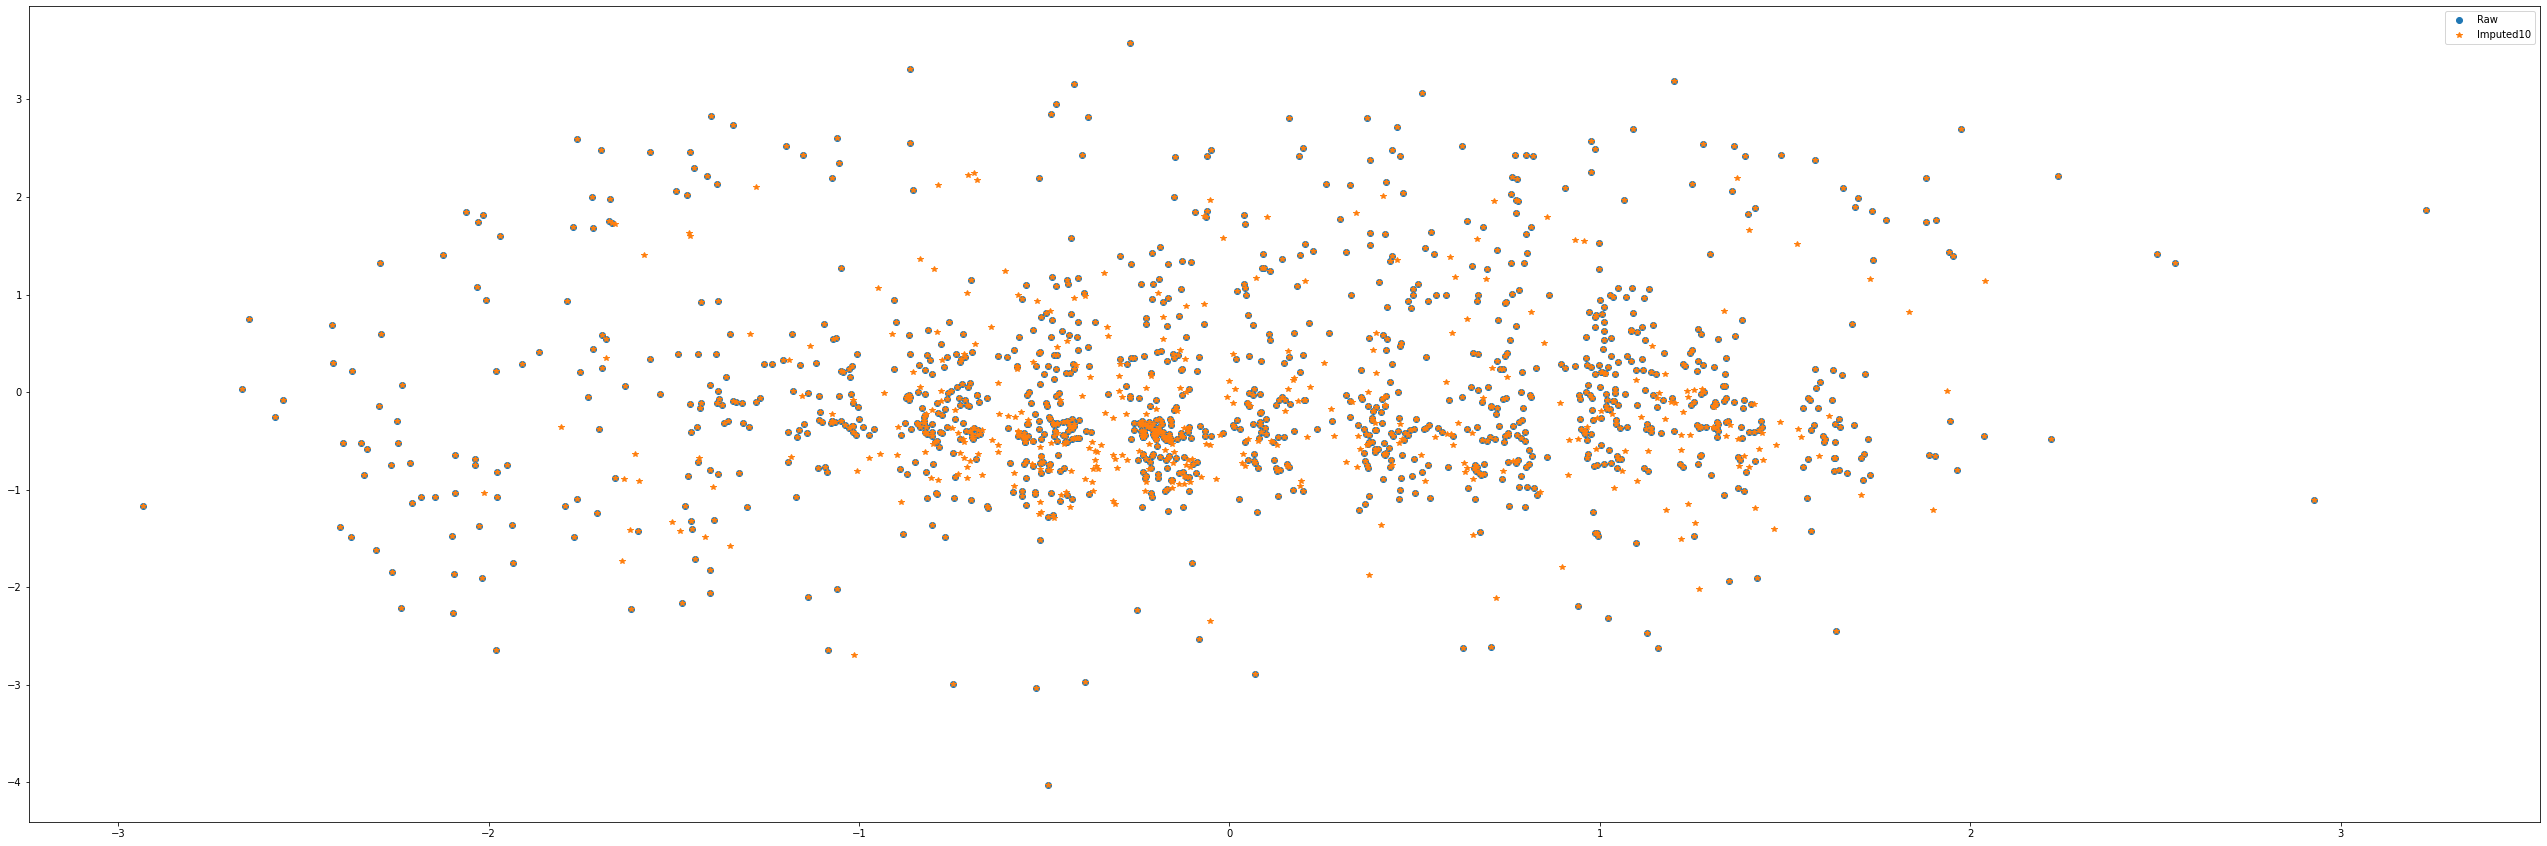

In [143]:
x_name = 'neuron4615_x'
y_name = 'neuron4615_y'
all_neurons = list(df_with_likelihood.columns)
i_x = all_neurons.index(x_name)
i_y = all_neurons.index(y_name)

x = dat_normalized[:, i_x]
x_impute10 = ppca10.data[:, i_x]
y = dat_normalized[:, i_y]
y_impute10 = ppca10.data[:, i_y]

# %matplotlib widget
plt.figure(figsize=(45,15))

plt.plot(x, y, 'o', label='Raw', lw=5)
plt.plot(x_impute10, y_impute10, '*', label='Imputed10')
plt.legend()


In [119]:
# SAVE
from pathlib import Path
fname = f"Y:/shared_projects/wbfm/dlc_stacks/{project_fname}/3-tracking/postprocessing/full_3d_tracks.h5"

df_imputed.to_hdf(fname, 'df_with_missing')

df_imputed.to_csv(Path(fname).with_suffix('.csv'))

# Use both PPCA and kalman filtering

In [67]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ppca import PPCA
from pykalman import KalmanFilter
from numpy import ma

In [98]:
# DATA

# Get the final 3d tracks from a project
project_fname = "Charlie-worm3-new-seg";

# FILTERED BY DLC
fname = f"Y:/shared_projects/wbfm/dlc_stacks/{project_fname}/3-tracking/full_3d_tracks.h5"
df_raw = pd.read_hdf(fname)

df_with_likelihood = df_raw.copy()
df_with_likelihood.columns = ["_".join(a) for a in df_with_likelihood.columns.to_flat_index()]
to_keep = [c for c in df_with_likelihood.columns if 'likelihood' not in c.lower()]
df = df_with_likelihood[to_keep].copy()


In [149]:
def impute_using_ppca(df_to_impute, d=10):
    df_dat = df_to_impute.to_numpy()
    scaler = StandardScaler()
    scaler.fit(df_dat)
    dat_normalized = scaler.transform(df_dat)

    # Actually impute
    ppca = PPCA()
    ppca.fit(data=dat_normalized, d=d, verbose=False)

    dat_imputed = scaler.inverse_transform(ppca.data)
    df_deriv_imputed = pd.DataFrame(data=dat_imputed, columns = df.columns)
    
    return df_deriv_imputed

In [150]:
# IMPUTE MISSING

# DLC uses zeros as "failed tracking"
# Replace with nan and scale
df.replace(0, np.NaN, inplace=True)
df_deriv = df.diff()[1:]

df_deriv_imputed = impute_using_ppca(df_deriv)
df_imputed = impute_using_ppca(df)

C:\Users\charles.fieseler\Anaconda3\envs\DLC-for-WBFM\lib\site-packages\ppca\_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds
C:\Users\charles.fieseler\Anaconda3\envs\DLC-for-WBFM\lib\site-packages\ppca\_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds


In [173]:
# KALMAN FILTER

name = 'neuron4615'
name_x = '_'.join([name, 'x'])
name_y = '_'.join([name, 'y'])

print(f"Analyzing: {name}")
derivs = np.array(df_deriv_imputed[name_x])
# vals = np.array(df[name_x][:-1])
vals = np.array(df_imputed[name_x][:-1])
# Missing due to low DLC confidence
likelihood_thresh = 0.6
low_likelihood = df_raw[name]['likelihood'][:-1] < likelihood_thresh

# Use numpy masked arrays to incorporate missing value
derivs = ma.masked_array(derivs, fill_value=0) # Derivs are good even at bad DLC locations
vals = ma.masked_array(vals, mask=low_likelihood, fill_value=0) 

# Apply projected corrections via a kalman filter
A = np.array([[1.0, 1.0], 
              [0.0, 0.9]]) # Position and velocity
C = np.array([[1.0, 0.0], 
              [0.0, 1.0]]) # Both are observed
measurements = ma.vstack([vals, derivs]).T
initial_state_mean = np.array([np.mean(vals), 0.0])
observation_covariance = np.array([[2.0, 0.0], 
                                   [0.0, 2.0]])
kf = KalmanFilter(transition_matrices=A,
                  observation_matrices=C,
                  observation_covariance=observation_covariance,
                  initial_state_mean=initial_state_mean,
                  em_vars=['transition_covariance', 'observation_covariance'])

Analyzing: neuron4615


In [174]:
kf = kf.em(measurements, n_iter=5)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)

In [175]:
kf.observation_covariance

array([[ 20.81865333, -21.21574444],
       [-21.21574444,  45.90948658]])

In [176]:
%matplotlib widget
which_dim = 0

plt.title(f"Position for {name}")
y = smoothed_state_means[:,which_dim]
err = smoothed_state_covariances[:,which_dim,which_dim]
plt.fill_between(range(len(y)), y+err, y-err, label="Kalman estimated variance", color='k', alpha=0.5)
plt.plot(y, label="Smoothed", lw=3)
plt.plot(measurements[:,which_dim], lw=3, label="Measurements (high DLC confidence)")
plt.plot(df[name_x], 'o', label="Raw")
plt.plot(df_imputed[name_x], '--', label="Measurements (imputed)")
# plt.ylim([min(measurements[:,which_dim]), max(measurements[:,which_dim])])
plt.ylim([min(y), max(y)])
plt.legend()
plt.savefig(f'Kalman_test_{name}.png')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [44]:
# is_nan = set(list(np.where(df[name_x].isnull()))[0])
# is_low = set(list(np.where(low_likelihood)[0]))

# is_nan.issubset(is_low)

In [109]:
# np.where(np.isnan(derivs))
np.where(np.isnan(measurements[~measurements.mask])), np.where(~np.isfinite(measurements[~measurements.mask]))

((array([], dtype=int64),), (array([], dtype=int64),))

In [116]:
np.where(np.isnan(derivs.data))

(array([], dtype=int64),)

# Do everything in functions

In [2]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ppca import PPCA
from pykalman import KalmanFilter
from numpy import ma
from tqdm.auto import tqdm

In C:\Users\charles.fieseler\Anaconda3\envs\DLC-for-WBFM\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\charles.fieseler\Anaconda3\envs\DLC-for-WBFM\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\charles.fieseler\Anaconda3\envs\DLC-for-WBFM\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\charles.fieseler\Anaconda3\envs\DLC-for-WBFM\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed tw

In [7]:
def get_data(project_fname):
    # Get the final 3d tracks from a project

    # FILTERED BY DLC
    fname = f"Y:/shared_projects/wbfm/dlc_stacks/{project_fname}/3-tracking/full_3d_tracks.h5"
    df_raw = pd.read_hdf(fname)

    df_with_likelihood = df_raw.copy()
    df_with_likelihood.columns = ["_".join(a) for a in df_with_likelihood.columns.to_flat_index()]
    to_keep = [c for c in df_with_likelihood.columns if 'likelihood' not in c.lower()]
    df = df_with_likelihood[to_keep].copy()

    df.replace(0, np.NaN, inplace=True)
    df_deriv = df.diff()[1:]
    
    return df, df_deriv, df_raw

def impute_using_ppca(df_to_impute, d=10):
    df_dat = df_to_impute.to_numpy()
    scaler = StandardScaler()
    scaler.fit(df_dat)
    dat_normalized = scaler.transform(df_dat)

    # Actually impute
    ppca = PPCA()
    ppca.fit(data=dat_normalized, d=d, verbose=False)

    dat_imputed = scaler.inverse_transform(ppca.data)
    df_deriv_imputed = pd.DataFrame(data=dat_imputed, columns = df.columns)
    
    return df_deriv_imputed

def filter_one_neuron(name, df_deriv_imputed, df_imputed, df_raw, likelihood_thresh=0.6, kalman_noise_level=2.0):
    # KALMAN FILTER
    name_x = '_'.join([name, 'x'])
    name_y = '_'.join([name, 'y'])
    
    all_names = [name_x, name_y]
    one_neuron_data_dict = {}
    
    for this_name in all_names:
#         print(f"Analyzing: {name}")
        derivs = np.array(df_deriv_imputed[this_name])
        vals = np.array(df_imputed[this_name][:-1])
        # Missing due to low DLC confidence
        low_likelihood = df_raw[name]['likelihood'][:-1] < likelihood_thresh
    
        smoothed_state_means, smoothed_state_covariances = filter_array(vals, derivs, low_likelihood, kalman_noise_level)
        
        # Will turn into a dataframe
        one_neuron_data_dict[this_name] = smoothed_state_means[:, 0]
        
    return one_neuron_data_dict

def filter_array(vals, derivs, low_likelihood, kalman_noise_level):
    # Use numpy masked arrays to incorporate missing value
    derivs = ma.masked_array(derivs, fill_value=0) # Derivs are good even at bad DLC locations
    vals = ma.masked_array(vals, mask=low_likelihood, fill_value=0) 

    # Apply projected corrections via a kalman filter
    A = np.array([[1.0, 1.0], 
                  [0.0, 0.9]]) # Position and velocity
    C = np.array([[1.0, 0.0], 
                  [0.0, 1.0]]) # Both are observed
    measurements = ma.vstack([vals, derivs]).T
    initial_state_mean = np.array([np.mean(vals), 0.0])
    observation_covariance = np.array([[kalman_noise_level, 0.0], 
                                       [0.0, kalman_noise_level]])
    kf = KalmanFilter(transition_matrices=A,
                      observation_matrices=C,
                      observation_covariance=observation_covariance,
                      initial_state_mean=initial_state_mean,
                      em_vars=['transition_covariance', 'observation_covariance'])
    
    kf = kf.em(measurements, n_iter=5)
    (smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)
    
    return smoothed_state_means, smoothed_state_covariances

In [8]:
# DATA
project_fname = "Charlie-worm3-new-seg";

df, df_deriv, df_raw = get_data(project_fname)

df_deriv_imputed = impute_using_ppca(df_deriv)
df_imputed = impute_using_ppca(df)

all_names = list(df_raw.columns.levels[0])
df_smoothed_dict = {}
for name in tqdm(all_names):
    dat = filter_one_neuron(name, df_deriv_imputed, df_imputed, df_raw, likelihood_thresh=0.6, kalman_noise_level=2.0)
    df_smoothed_dict.update(dat)

C:\Users\charles.fieseler\Anaconda3\envs\DLC-for-WBFM\lib\site-packages\ppca\_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds
C:\Users\charles.fieseler\Anaconda3\envs\DLC-for-WBFM\lib\site-packages\ppca\_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds


  0%|          | 0/74 [00:00<?, ?it/s]

# Use GUI to visualize these "corrected" tracks

# Visualize spheres around the tracks

In [1]:
import napari, zarr
import pandas as pd
# import raster_geometry.raster
from DLC_for_WBFM.utils.postprocessing.base_cropping_utils import get_crop_coords3d

In [74]:
project_fname = "Charlie-immobilized-long";
fname = f"Y:/shared_projects/wbfm/dlc_stacks/{project_fname}/1-segmentation/masks_4500.zarr"
z1 = zarr.open(fname)

fname = f"Y:/shared_projects/wbfm/dlc_stacks/{project_fname}/3-tracking/full_3d_tracks-no-filter.h5"
df_raw = pd.read_hdf(fname)

In [82]:
masks_zarr = zarr.zeros_like(z1, path='tmp.zarr')

# s = zarr.DirectoryStore('tmp.zarr')
# masks_zarr = zarr.zeros_like(z1, store=s)
# s.close()
# masks_zarr = zarr.open('tmp.zarr',
#                        shape=z1.chunks, chunks=z1.chunks, dtype=np.uint16,
#                        fill_value=0,
#                        synchronizer=zarr.ThreadSynchronizer())

In [83]:
# %%timeit

# t = 2
# neuron = 'neuron0'
# tmp = df_raw[neuron]
# z,x,y = [int(tmp['z'][t]), int(tmp['x'][t]), int(tmp['y'][t])]
# sphere = raster_geometry.raster.sphere(shape=z2.chunks[1:],radius=5, position=[z,x,y])
# z2[t,...] = 2*np.array(sphere)

In [85]:
# %%timeit

t = 0
for i, neuron in enumerate(['neuron1', 'neuron2', 'neuron3']):
    tmp = df_raw[neuron]
    z,y,x = [int(tmp['z'][t]), int(tmp['x'][t]), int(tmp['y'][t])]
    masks_zarr[t,z-2:z+2,x-5:x+5,y-5:y+5] = i+1

In [86]:
viewer = napari.view_labels(masks_zarr)
viewer.add_labels(z1)


<Labels layer 'z1' at 0x1d947675288>

In [72]:
z3 = zarr.open('tmp.zarr')
viewer = napari.view_labels(z3)
viewer.add_labels(z1)

<Labels layer 'z1' at 0x1d94b26e748>

In [24]:
import numpy as np
def get_clipped_sizes(z, sz, total_sz):
    return int(np.clip(z-sz, a_min=0, a_max=None)), int(np.clip(z+sz+1, a_max=total_sz, a_min=None))
    

In [27]:
fname = r"Y:\shared_projects\wbfm\dlc_stacks\Charlie-immobilized-long\3-tracking\segmentation_from_tracking.zarr"
z = zarr.open(fname)
napari.view_labels(z)

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 66.0, 166.0), zoom=3.914457831325301, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(0.0, 0.0, 0.0, 0.0), scaled=True, size=10, style='standard'), dims=Dims(ndim=4, ndisplay=2, last_used=3, range=((0.0, 4499.0, 1.0), (0.0, 32.0, 1.0), (0.0, 132.0, 1.0), (0.0, 332.0, 1.0)), current_step=(0, 0, 0, 0), order=(0, 1, 2, 3), axis_labels=('0', '1', '2', '3')), grid=GridCanvas(enabled=False, stride=1, shape=(-1, -1)), layers=[<Labels layer 'z' at 0x250dbd2e708>], scale_bar=ScaleBar(visible=False, colored=False, ticks=True, position='bottom_right', font_size=10.0, unit=None), text_overlay=TextOverlay(visible=False, color=array([1., 1., 1., 1.]), font_size=10.0, position='top_left', text=''), help='enter paint or fill mode to edit labels', status='Ready', theme='dark', title='napari', mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_wheel_

In [15]:
# DEBUG
from DLC_for_WBFM.utils.projects.utils_project import load_config
from pathlib import Path
from DLC_for_WBFM.utils.projects.utils_project import safe_cd
import pandas as pd
import os
import numpy as np
project_path = r"Y:\shared_projects\wbfm\dlc_stacks\Charlie-immobilized-long\project_config.yaml"

%load_ext autoreload
%autoreload 2
# Manually load yaml files
project_cfg = load_config(project_path)

track_fname = Path(project_cfg['subfolder_configs']['tracking'])
project_dir = Path(project_path).parent
track_fname = Path(project_dir).joinpath(track_fname)
track_cfg = dict(load_config(track_fname))

segment_fname = Path(project_cfg['subfolder_configs']['segmentation'])
project_dir = Path(project_path).parent
segment_fname = Path(project_dir).joinpath(segment_fname)
segment_cfg = dict(load_config(segment_fname))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
this_config = {'project_path':project_path, 'segment_cfg':segment_cfg, 'track_cfg':track_cfg, 'dataset_params':project_cfg['dataset_params']}
from DLC_for_WBFM.utils.visualization.utils_segmentation import create_spherical_segmentation

# create_spherical_segmentation(this_config, 0)

In [19]:

track_cfg = this_config['track_cfg']
seg_cfg = this_config['segment_cfg']

with safe_cd(Path(this_config['project_path']).parent):
    # Get original segmentation, just for shaping
    seg_fname = seg_cfg['output']['masks']
    seg_masks = zarr.open(seg_fname)

    # Initialize the masks at 0
    out_fname = os.path.join("3-tracking", "segmentation_from_tracking.zarr")
    print(f"Saving masks at {out_fname}")
    new_masks = zarr.open_like(seg_masks, path=out_fname,
                       synchronizer=zarr.ThreadSynchronizer())
    mask_sz = new_masks.shape

    # Get the 3d DLC tracks
    df_fname = track_cfg['final_3d_tracks']['df_fname']
    df = pd.read_hdf(df_fname)

neuron_names = df.columns.levels[0]
num_frames = mask_sz[0]
chunk_sz = new_masks.chunks

# Generate spheres for each neuron, for all time
cube_sz = [2, 4, 4]

def get_clipped_sizes(this_sz, sz, total_sz):
    lower_dim = int(np.clip(this_sz - sz, a_min=0, a_max=total_sz))
    upper_dim = int(np.clip(this_sz + sz + 1, a_max=total_sz, a_min=0))
    return lower_dim, upper_dim

def parallel_func(i_time: int, ind_neuron: int, this_df: pd.DataFrame):
    # X=col, Y=row
    z, col, row = [int(this_df['z'][i_time]), int(this_df['x'][i_time]), int(this_df['y'][i_time])]
    # Instead do a cube (just for visualization)
    z0, z1 = get_clipped_sizes(z, cube_sz[0], chunk_sz[1])
    row0, row1 = get_clipped_sizes(row, cube_sz[1], chunk_sz[2])
    col0, col1 = get_clipped_sizes(col, cube_sz[2], chunk_sz[3])
    new_masks[i_time, z0:z1, row0:row1, col0:col1] = ind_neuron + 1  # Skip 0

Saving masks at 3-tracking\segmentation_from_tracking.zarr


In [26]:
i = 0
ind_neuron = 12
neuron = 'neuron10'
parallel_func(i, ind_neuron, this_df=df[neuron])

# Do the matches from DLC - seg give good confidence values?


In [32]:
df_match = pd.read_pickle(r"Y:\shared_projects\wbfm\dlc_stacks\Charlie-immobilized-long\4-traces\all_matches.pickle")

In [43]:
import matplotlib.pyplot as plt
from ipywidgets import interact

interactive(children=(IntSlider(value=2250, description='i', max=4500), Output()), _dom_classes=('widget-inter…

<function __main__.f(i)>

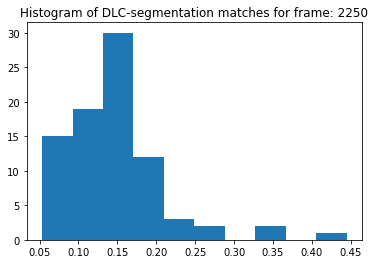

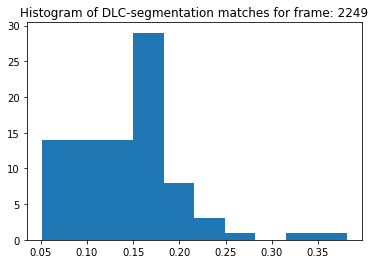

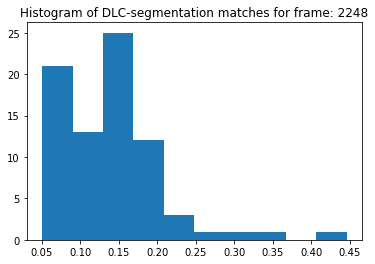

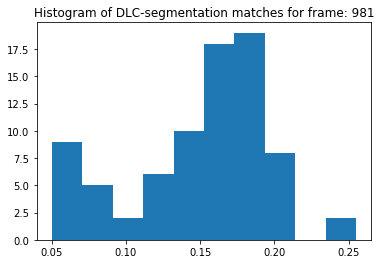

In [50]:
%matplotlib inline
def f(i):
    plt.hist([tmp[0] for tmp in df_match[i][:,-1]]);
    plt.title(f"Histogram of DLC-segmentation matches for frame: {i}")
interact(f, i=(0,len(df_match)))

[0.1745436146964677,
 0.2354662559634602,
 0.15141522172237118,
 0.15414039922121106,
 0.1889018673769187,
 0.17517499551803872,
 0.17436296729259917,
 0.11294243735265422,
 0.17498525078055072,
 0.17518399823198288,
 0.09376782385979335,
 0.254676107772895,
 0.2004868929739811,
 0.15811071394799772,
 0.25170636015647796,
 0.16527713014207976,
 0.1353598405208397,
 0.1748621740595534,
 0.2039364391199262,
 0.1564029657894594,
 0.12526054449786664,
 0.13417435400983097,
 0.17650777106938437,
 0.18656638682425236,
 0.14164455339892532,
 0.18213372626627272,
 0.18759754835623743,
 0.1717664339074931,
 0.2077284779780629,
 0.21878688881443206,
 0.13776334319467196,
 0.1927317181629319,
 0.21221904140184233,
 0.16158351296727222,
 0.19100241247047264,
 0.21854846088739832,
 0.16443454204082966,
 0.16326782293975745,
 0.20700026607073357,
 0.1551001021085829,
 0.1479702700918491,
 0.16318305526680218,
 0.1705949972058829,
 0.1961791502368726,
 0.14983943893255486,
 0.2102400878014882,
 0.161

In [ ]:
# Redo trace extraction with new dataframe